<a href="https://colab.research.google.com/github/ramonVDAKKER/panel-unit-root-testing/blob/main/notebooks/WIP_panel_unit_roots_sims.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTEBOOK SEMIPARAMETRIC UNIT ROOT TESTING FOR FIRST-GENERATION PANEL DATA MODELS

## 0. IMPORTS

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm, uniform
from scipy.stats import t as student_t

In [ ]:
b = 1

## 1. Specify functions and demos

### 1.1 Data Generating Process

In [ ]:
def generate_dataset(n: int, T: int, h: float, option_distribution: str):
    """Generate one dataset."""

    X = np.zeros((n, T + 1)) # first column concerns X_{\cdot, 0} = 0
    # TO DO: carefully think where to set seed
    # Autoregressions parameters
    auto_regression_parameters = np.ones((n,)) + h / (T * np.sqrt(n)) # TO DO: add possibility to add heterogeneity H_i

    if option_distribution == "Gaussian_iid_setting1":
        innovation =  norm.rvs(loc=0, scale=1, size=(n, T)) # Gaussian iid (also over i!) innovations
         # TO DO: Implement different error distributions and heterogeneity in variances, specifications with serial dependence   
    elif option_distribution == "Gaussian_inid_setting1":
        sigma_i = .5 +  uniform.rvs(size=(n, T))
        innovation = norm.rvs(loc=0, scale=sigma_i, size=(n, T))

    elif option_distribution == "Student_iid_setting1":
        innovation = student_t.rvs(5, size=(n, T))
    
    for t in range(1, T + 1, 1):
        X[:, t] = np.multiply(auto_regression_parameters, X[:, t - 1]) + innovation[:, t - 1]  
    # All the tests that we will consider will be invariant with respect to intercepts, so the following lines should not have any impact on outcomes
    intercepts = norm.rvs(loc=0, scale=1, size=(n, 1))
    Y = np.repeat(intercepts,  T + 1, axis=1) + X 
    return Y

Some sample paths of a simulated dataset:

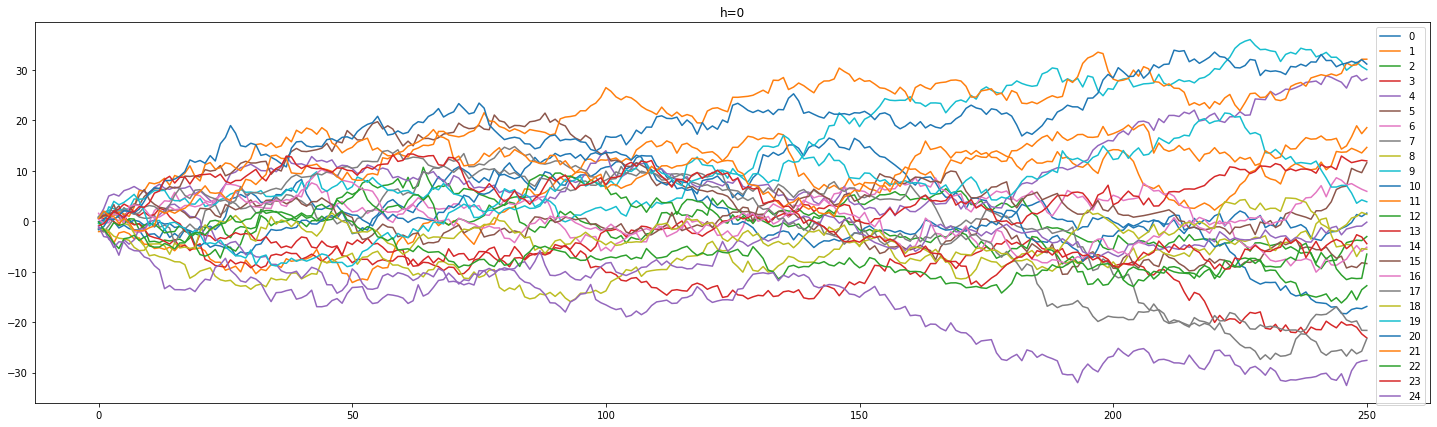

In [ ]:
h = 0 
Y =  generate_dataset(n=25, T=250, h=0, option_distribution="Gaussian_inid_setting1")
pd.DataFrame(Y.T).plot(figsize=(25, 7), title=f"h={h}")

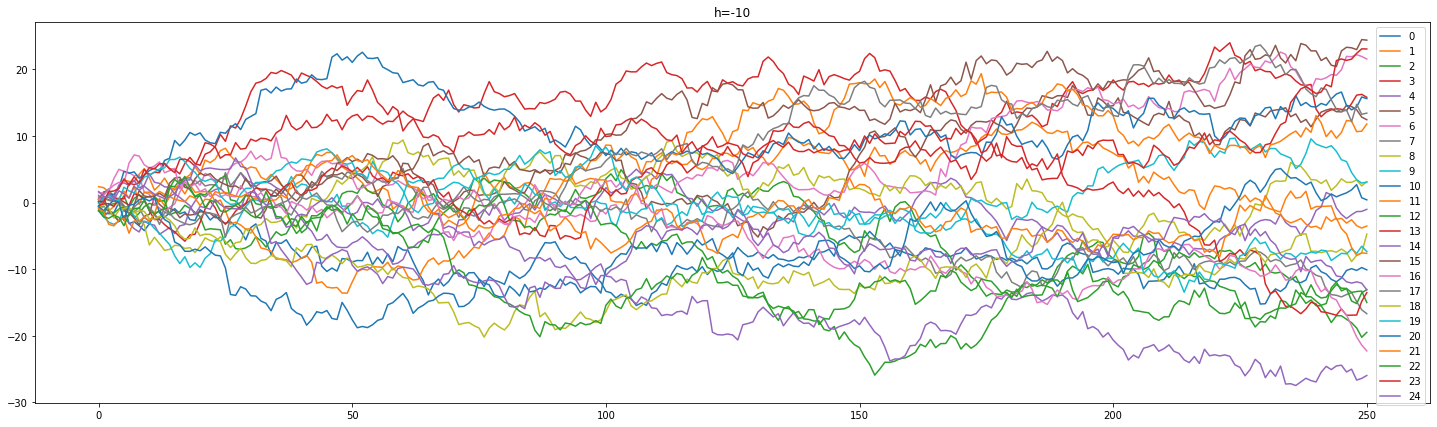

In [ ]:
h = -10
Y =  generate_dataset(n=25, T=250, h=-5, option_distribution="Gaussian_inid_setting1")
pd.DataFrame(Y.T).plot(figsize=(25, 7), title=f"h={h}")

### 1.3 Specifiy Gaussian test (imposing no serial dependence in innovations)


In [ ]:
def test_gaussian_no_serial_dependence(dataset, alpha = 0.05):

    n, T = dataset.shape
    delta = dataset[:, 1: ] - dataset[:, :-1]
    hat_sigmas = np.sum(np.power(delta, 2), axis=1) / (T - 1)
    aux = np.zeros((n,))
    for t in range(0, T - 1, 1):
        aux += np.multiply( (dataset[:, t] - dataset[:, 0]), delta[:, t])
    aux = np.divide(aux, hat_sigmas)
    t = (np.sum(aux) / (T * np.sqrt(n))) * np.sqrt(2)
    phi = t < norm.ppf(alpha)
    return t, phi

## 1.4 Power for Gaussian inid case - Gaussian test

In [ ]:
def MC_proxy_power(n, T, h, distribution_innovations, num_replications=5000):
    ts = np.zeros(num_replications)
    phi = np.zeros(num_replications)
    for rep in range(0, num_replications):
        data =  generate_dataset(n, T, h, distribution_innovations)
        ts[rep], phi[rep] =  test_gaussian_no_serial_dependence(data, alpha = 0.05)
    return np.mean(phi)

In [ ]:
# Size:
MC_proxy_power(250, 100, h=0,  distribution_innovations="Gaussian_inid_setting1", num_replications=5000)

0.0386

In [ ]:
# Power:
MC_proxy_power(250, 100, h=-2,  distribution_innovations="Gaussian_inid_setting1", num_replications=5000)

0.3358

In [ ]:
def power_envelope(h, dgp, alpha=0.05):
    if dgp == "gaussian":
        J = 1 / 2
    c =  norm.ppf(alpha)
    return norm.cdf(c -h * np.sqrt(J))

In [ ]:
power_envelope(-2, "gaussian")

0.4087972197938704

In [ ]:
# Power:
MC_proxy_power(1000, 250, h=-2,  distribution_innovations="Gaussian_inid_setting1", num_replications=5000)

0.3724

# 1.5 Student $t_5$ innovations iid - Gaussian test without serial depedence

In [ ]:
# Size:
MC_proxy_power(250, 100, h=0,  distribution_innovations="Student_iid_setting1", num_replications=5000)

0.0394

In [ ]:
# Size:
MC_proxy_power(250, 100, h=-2,  distribution_innovations="Student_iid_setting1", num_replications=5000)

0.3426